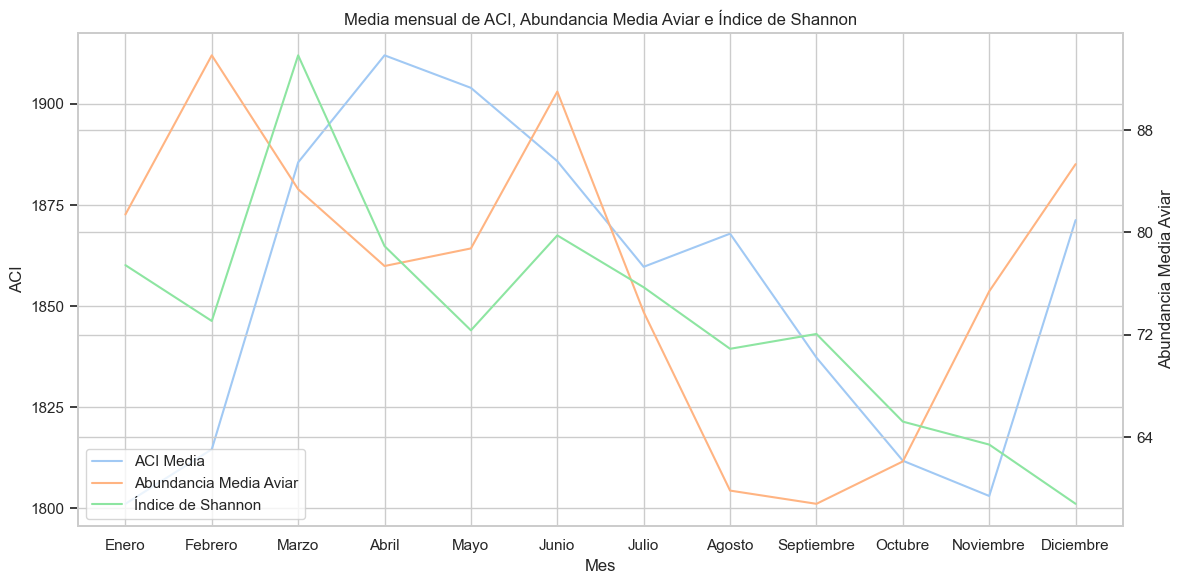

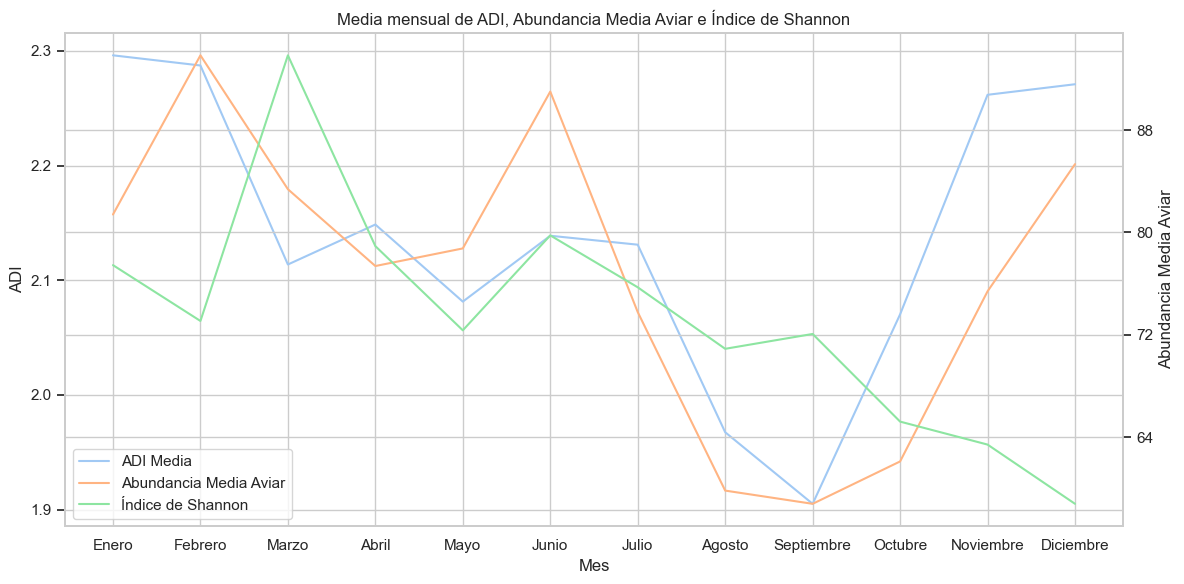

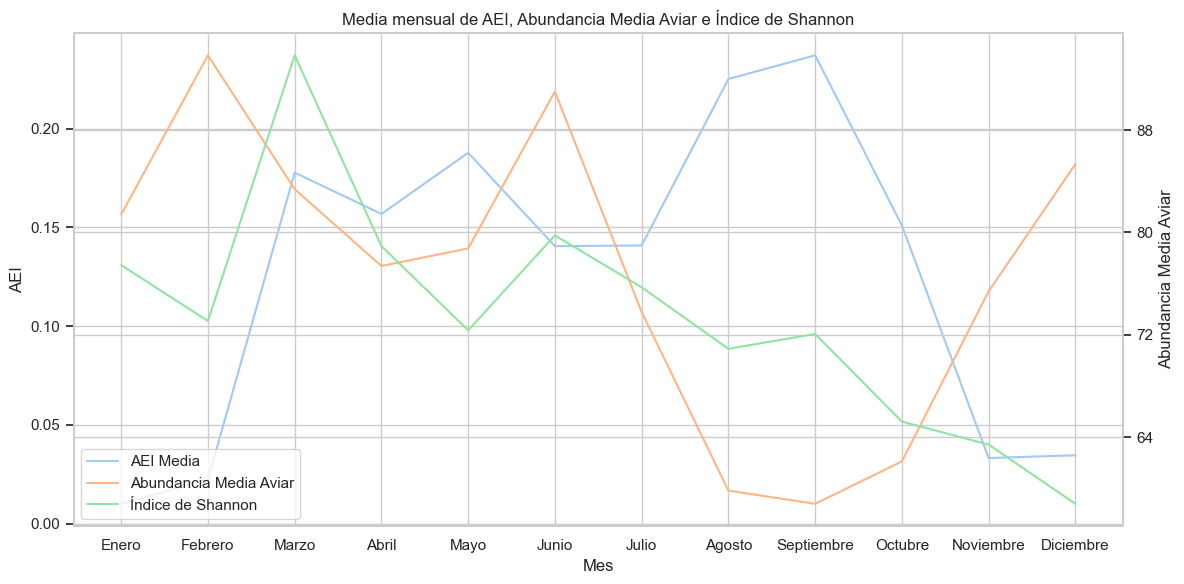

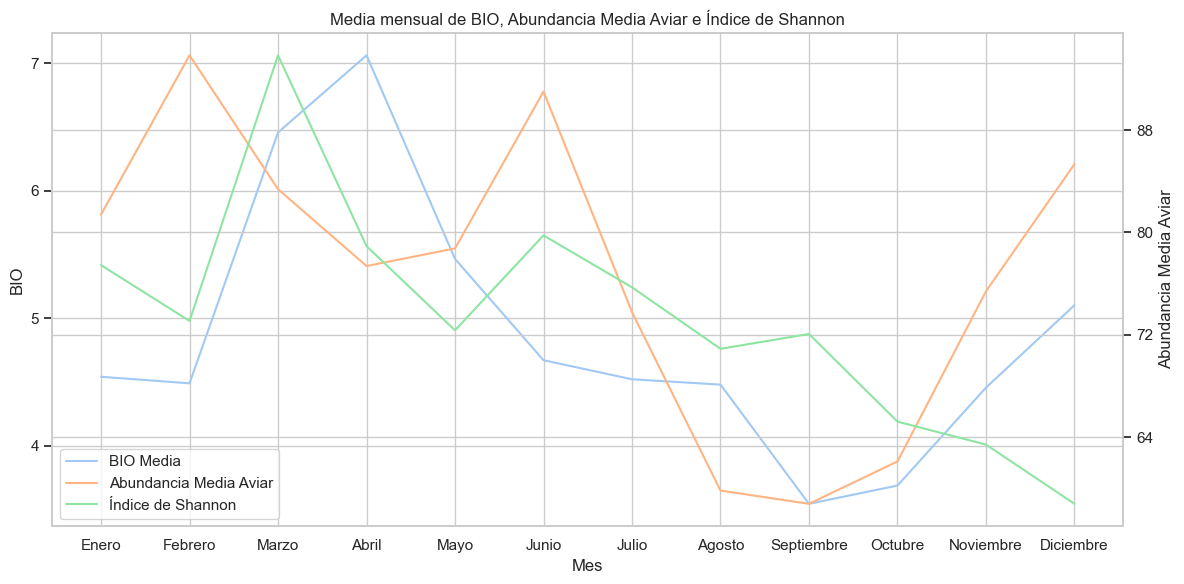

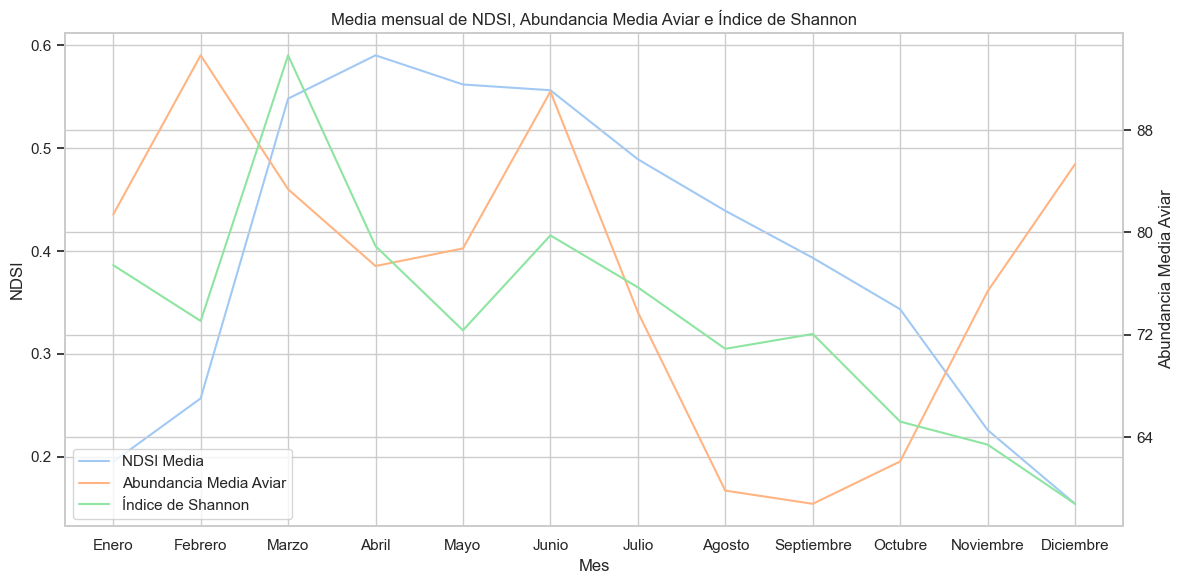

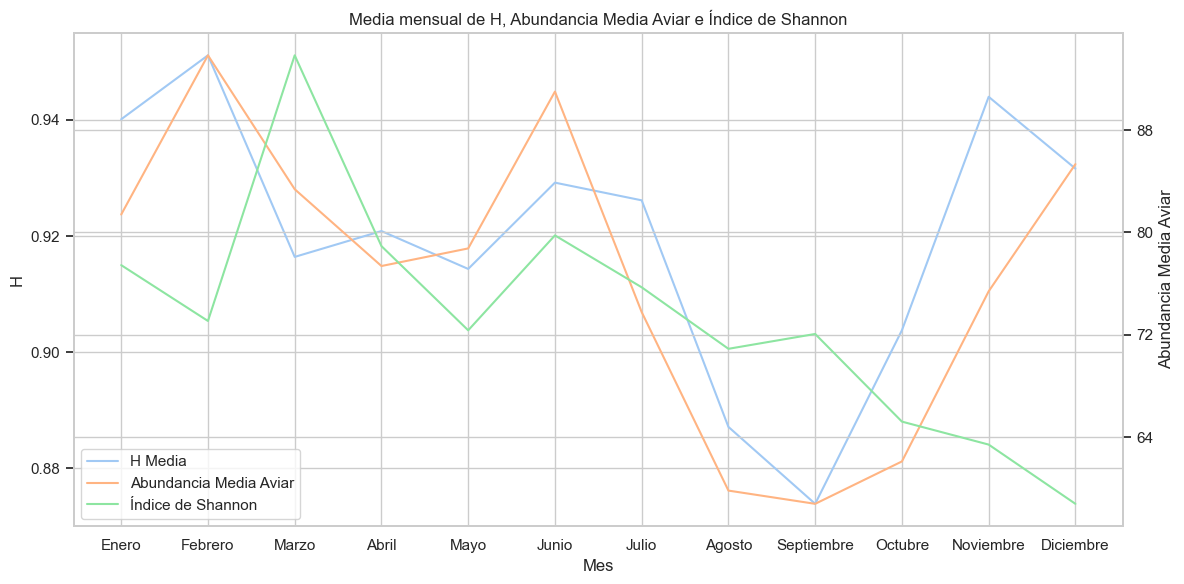

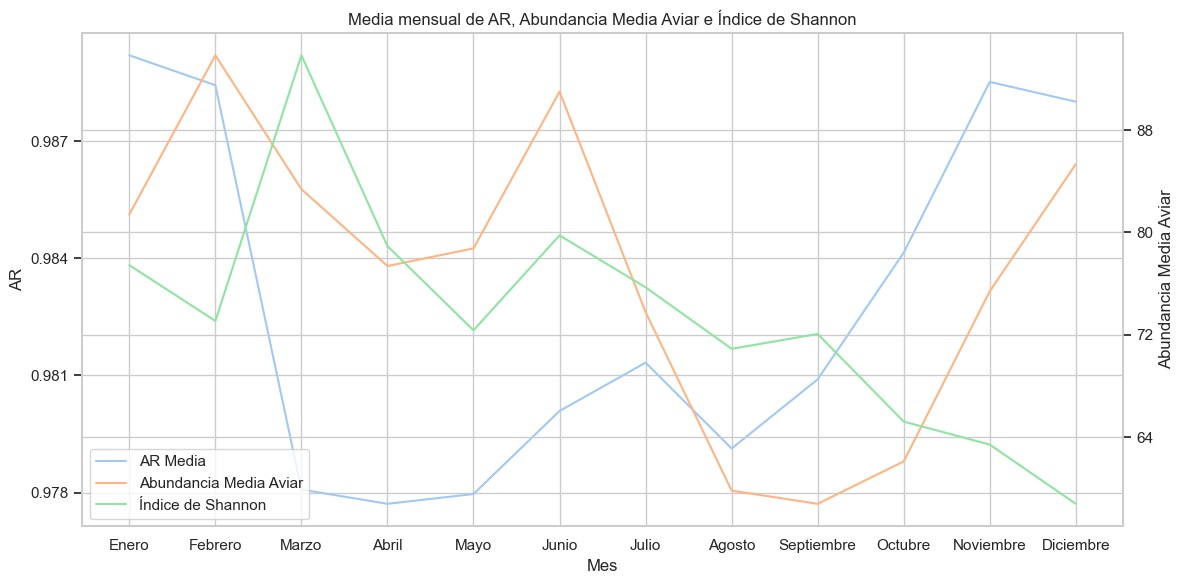

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# --- 1. Conexión y extracción de datos desde SQLite ---
db_path = "../../db/audio_metadata.db"
conn = sqlite3.connect(db_path)
df_audio = pd.read_sql_query("SELECT * FROM audio_metadata WHERE processed = TRUE", conn)
df_obs = pd.read_sql_query("SELECT * FROM observations", conn)
conn.close()

# --- 2. Conversión de fechas y extracción de mes ---
# Para audio_metadata:
df_audio["datetime"] = pd.to_datetime(df_audio["datetime"])
df_audio["month"] = df_audio["datetime"].dt.month

# Para observations (suponiendo que la columna se llama "datetime"):
df_obs["datetime"] = pd.to_datetime(df_obs["datetime"], errors='coerce')
df_obs["month"] = df_obs["datetime"].dt.month

# --- 3. Agregación mensual para audio_metadata ---
# Lista de índices a evaluar
indices = ["ACI", "ADI", "AEI", "BIO", "NDSI", "H", "AR"]

# Asegurarse de que en df_audio hay valores en los índices
df_audio = df_audio.dropna(subset=indices)

# Agrupar por mes y calcular la media para cada índice
audio_monthly = df_audio.groupby("month")[indices].mean().reset_index()

# --- 4. Agregación diaria y media mensual para observaciones ---
# Crear una columna con la fecha sin la hora
df_obs["date_only"] = df_obs["datetime"].dt.date

# Calcular el número de observaciones (pájaros) por día
daily_obs = df_obs.groupby("date_only").size().reset_index(name="bird_count")

# Extraer el mes a partir de la fecha
daily_obs["month"] = pd.to_datetime(daily_obs["date_only"]).dt.month

# Calcular la media diaria de pájaros observados en cada mes
obs_monthly = daily_obs.groupby("month")["bird_count"].mean().reset_index(name="avg_bird_count")

# --- 5. Cálculo del índice de Shannon por mes ---
# Para el índice de Shannon, primero se agrupan las observaciones por mes y especie (pájaro)
df_shannon = df_obs.groupby(["month", "bird"]).size().reset_index(name="count")

# Calcular la proporción de cada 'bird' en cada mes
df_shannon["proporcion"] = df_shannon.groupby("month")["count"].transform(lambda x: x / x.sum())

# Calcular el índice de Shannon por mes
df_shannon["shannon"] = -df_shannon["proporcion"] * np.log(df_shannon["proporcion"])

# Sumar el índice de Shannon por mes
shannon_index_monthly = df_shannon.groupby("month")["shannon"].sum().reset_index(name="shannon_index")

# --- 6. Mapear número de mes a nombre en español y ordenar ---
month_names = {1: "Enero", 2: "Febrero", 3: "Marzo", 4: "Abril", 5: "Mayo", 6: "Junio",
               7: "Julio", 8: "Agosto", 9: "Septiembre", 10: "Octubre", 11: "Noviembre", 12: "Diciembre"}

audio_monthly["month_name"] = audio_monthly["month"].map(month_names)
obs_monthly["month_name"] = obs_monthly["month"].map(month_names)
shannon_index_monthly["month_name"] = shannon_index_monthly["month"].map(month_names)

audio_monthly = audio_monthly.sort_values("month")
obs_monthly = obs_monthly.sort_values("month")
shannon_index_monthly = shannon_index_monthly.sort_values("month")

# --- 7. Visualización con colores pastel de Seaborn ---
sns.set_theme(style="whitegrid", palette="pastel")
# Extraer colores pastel: usamos el primero para la media del índice, el segundo para la media de pájaros diarios,
# y el tercero para el índice de Shannon.
pastel_palette = sns.color_palette("pastel")
index_color = pastel_palette[0]
bird_color = pastel_palette[1]
shannon_color = pastel_palette[2]

for idx in indices:
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Graficar la media mensual del índice
    ax1.plot(audio_monthly["month_name"], audio_monthly[idx], color=index_color, label=f"{idx} Media")
    ax1.set_xlabel("Mes")
    ax1.set_ylabel(f"{idx}")
    ax1.tick_params(axis='y')

    # Crear un segundo eje para la media diaria de pájaros observados
    ax2 = ax1.twinx()
    ax2.plot(obs_monthly["month_name"], obs_monthly["avg_bird_count"], color=bird_color, label="Abundancia Media Aviar")
    ax2.set_ylabel("Abundancia Media Aviar")
    ax2.tick_params(axis='y')

    # Crear un tercer eje para el índice de Shannon (pero sin mostrar su eje)
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Desplazar el eje derecho
    ax3.plot(shannon_index_monthly["month_name"], shannon_index_monthly["shannon_index"], color=shannon_color, label="Índice de Shannon")
    ax3.set_ylabel("Índice de Shannon")
    ax3.tick_params(axis='y')
    ax3.yaxis.set_visible(False)  # Ocultar el eje Y del índice de Shannon

    # Ajustar los ticks para los ejes Y
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True, prune='lower', nbins=5))
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True, prune='lower', nbins=5))

    plt.title(f"Media mensual de {idx}, Abundancia Media Aviar e Índice de Shannon")

    # Combinar leyendas de los tres ejes y moverla a la parte inferior izquierda
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='lower left')

    plt.tight_layout()
    plt.show()

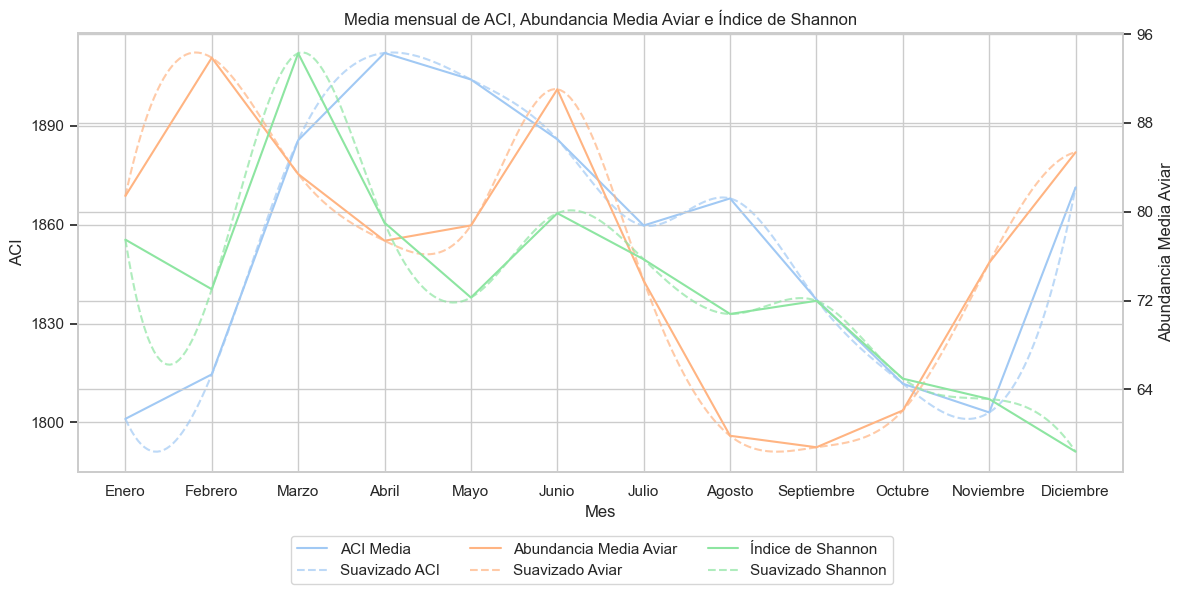

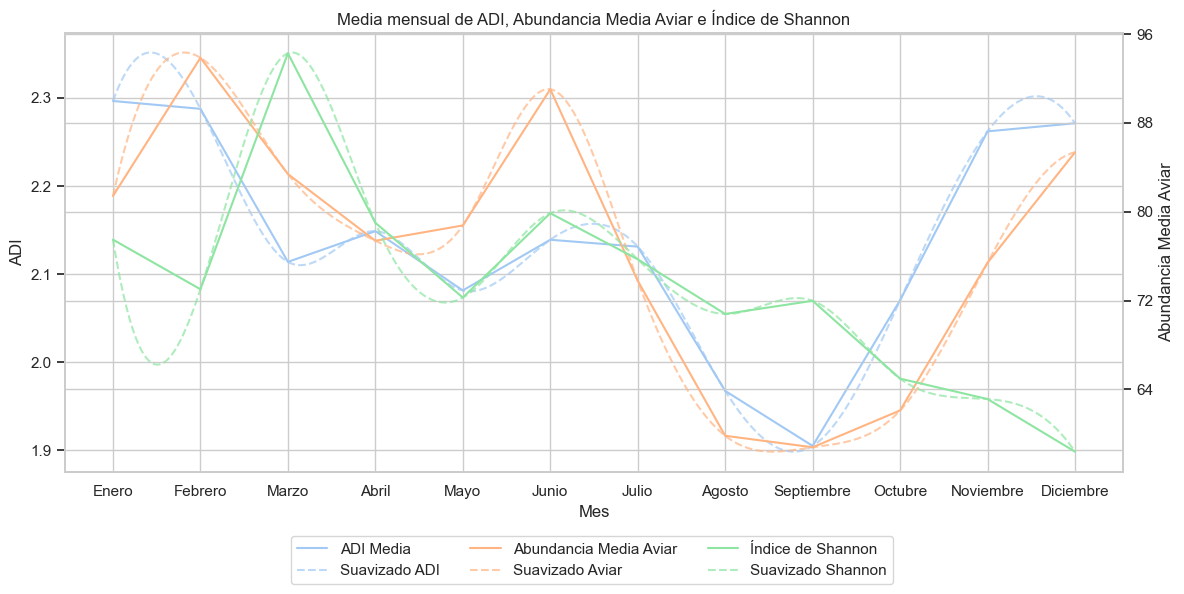

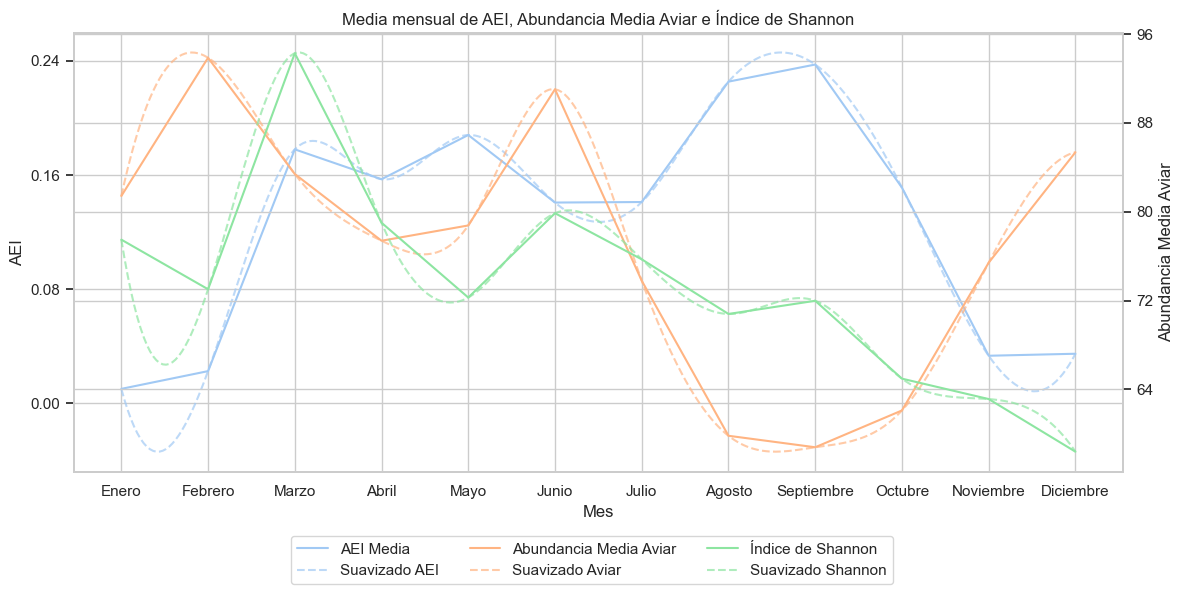

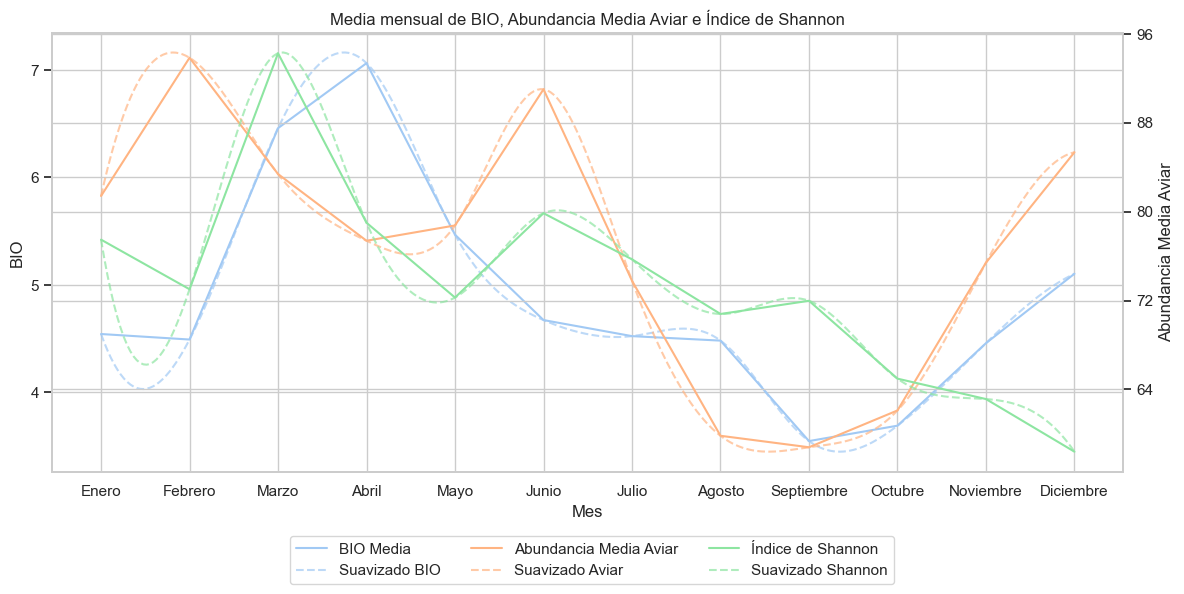

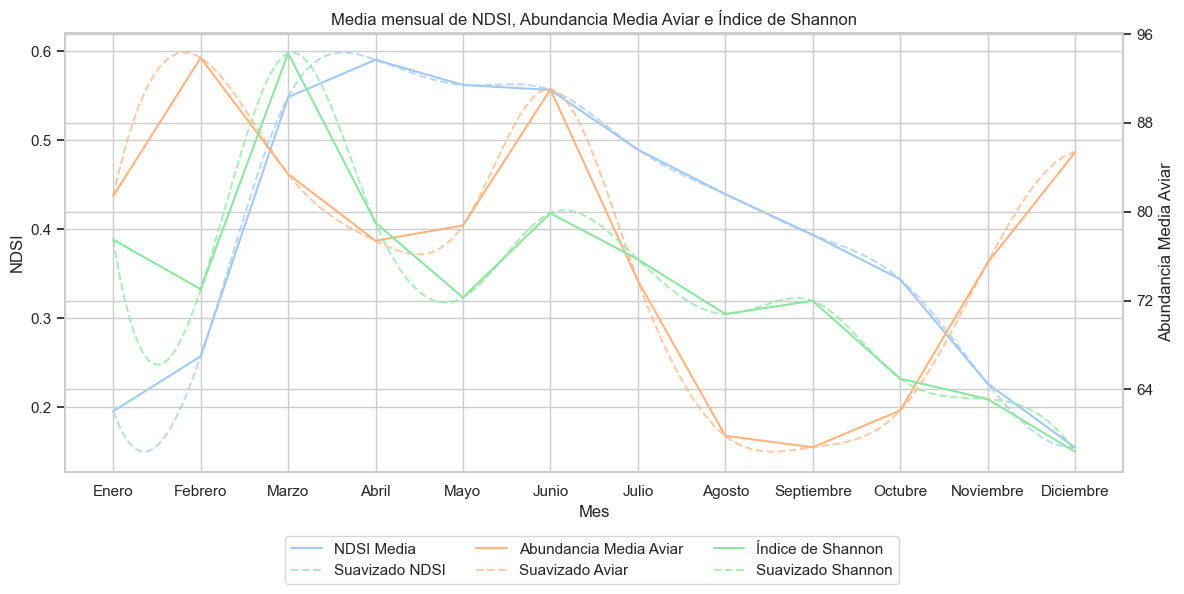

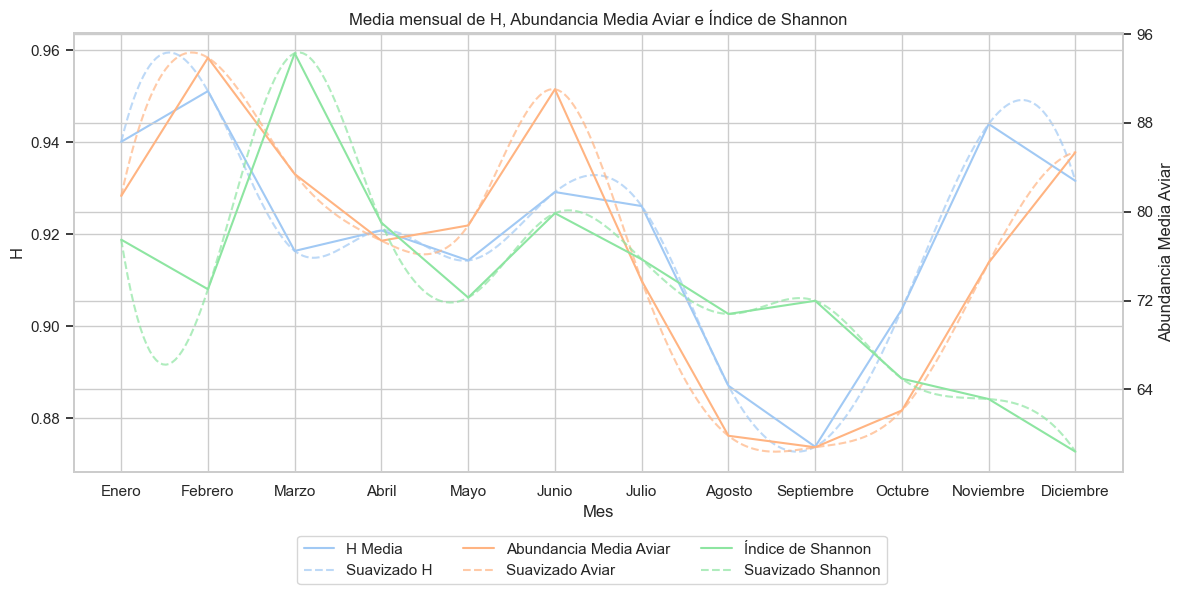

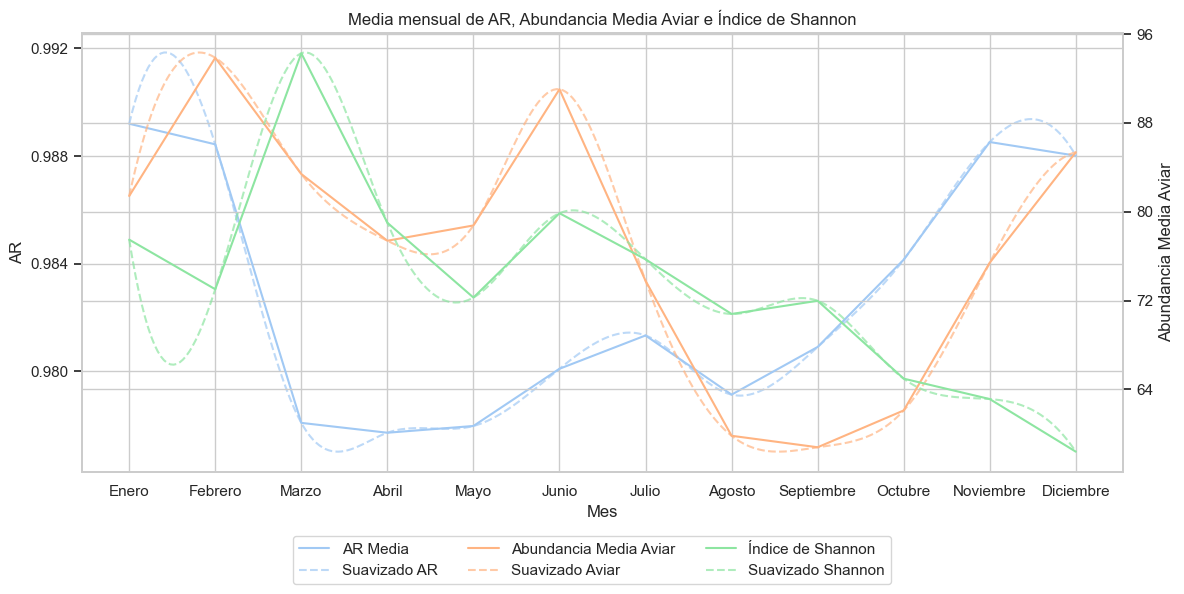

In [17]:
from scipy.interpolate import make_interp_spline

for idx in indices:
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Eje X: valor numérico para graficar y nombre para mostrar
    x = audio_monthly["month"]
    x_labels = audio_monthly["month_name"]

    # --- Índice acústico ---
    y_idx = audio_monthly[idx]
    ax1.plot(x, y_idx, color=index_color, label=f"{idx} Media")

    # Línea suave para índice acústico
    x_smooth = np.linspace(x.min(), x.max(), 300)
    spline_idx = make_interp_spline(x, y_idx, k=3)
    y_smooth_idx = spline_idx(x_smooth)
    ax1.plot(x_smooth, y_smooth_idx, color=index_color, linestyle="--", alpha=0.7, label=f"Suavizado {idx}")

    ax1.set_xlabel("Mes")
    ax1.set_ylabel(f"{idx}")
    ax1.tick_params(axis='y')

    # --- Abundancia de aves ---
    y_bird = obs_monthly["avg_bird_count"]
    ax2 = ax1.twinx()
    ax2.plot(x, y_bird, color=bird_color, label="Abundancia Media Aviar")

    # Línea suave para aves
    spline_bird = make_interp_spline(x, y_bird, k=3)
    y_smooth_bird = spline_bird(x_smooth)
    ax2.plot(x_smooth, y_smooth_bird, color=bird_color, linestyle="--", alpha=0.7, label="Suavizado Aviar")

    ax2.set_ylabel("Abundancia Media Aviar")
    ax2.tick_params(axis='y')

    # --- Índice de Shannon ---
    y_shannon = shannon_index_monthly["shannon_index"]
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.plot(x, y_shannon, color=shannon_color, label="Índice de Shannon")

    # Línea suave para Shannon
    spline_shannon = make_interp_spline(x, y_shannon, k=3)
    y_smooth_shannon = spline_shannon(x_smooth)
    ax3.plot(x_smooth, y_smooth_shannon, color=shannon_color, linestyle="--", alpha=0.7, label="Suavizado Shannon")

    ax3.set_ylabel("Índice de Shannon")
    ax3.tick_params(axis='y')
    ax3.yaxis.set_visible(False)

    # Etiquetas en el eje X con nombres de meses
    ax1.set_xticks(x)
    ax1.set_xticklabels(x_labels)

    # Ejes más legibles
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True, prune='lower', nbins=5))
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True, prune='lower', nbins=5))

    plt.title(f"Media mensual de {idx}, Abundancia Media Aviar e Índice de Shannon")

    # Combinar leyendas y ubicar debajo del gráfico
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    fig.legend(lines1 + lines2 + lines3,
               labels1 + labels2 + labels3,
               loc='lower center', ncol=3, bbox_to_anchor=(0.5, 0))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    plt.show()

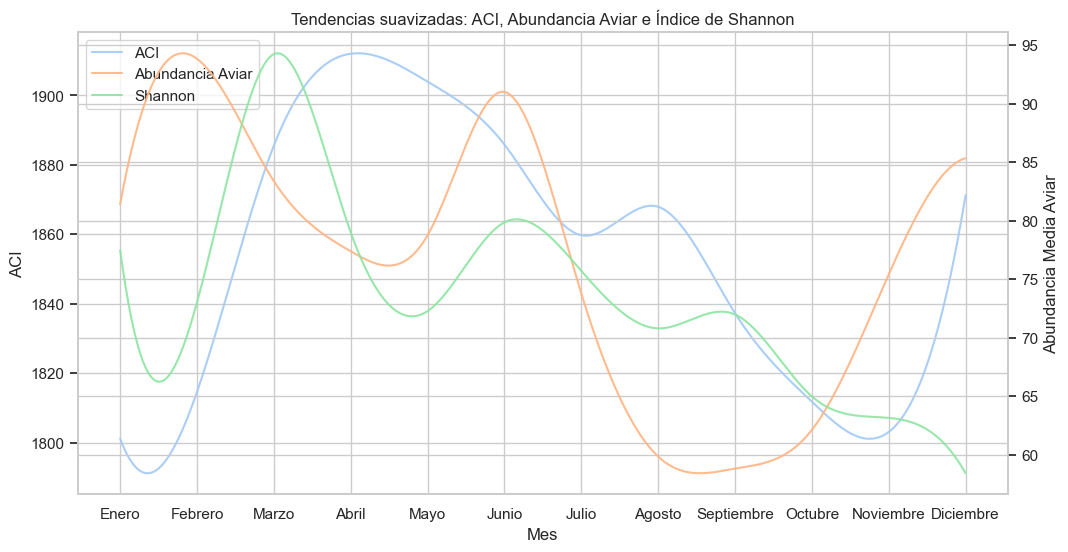

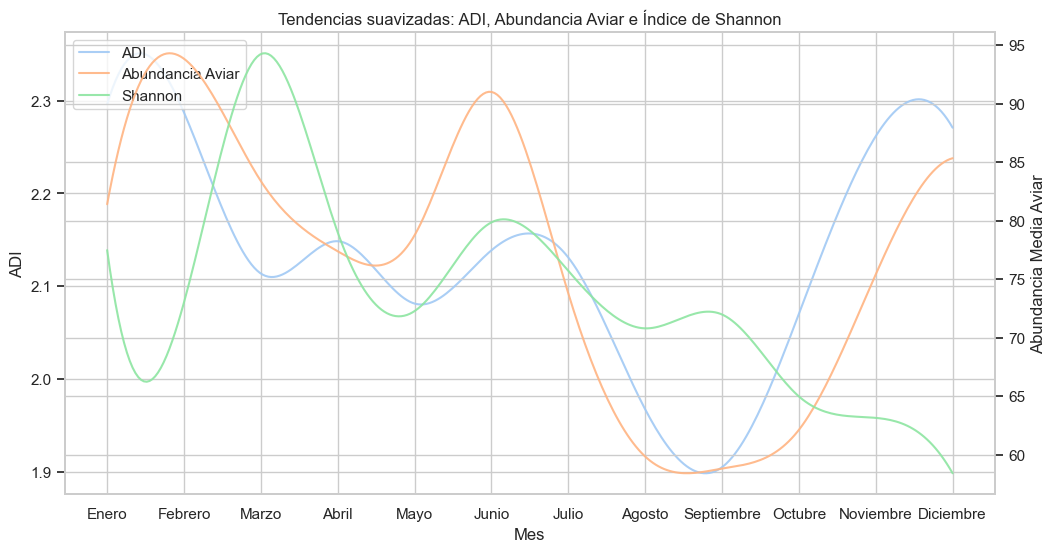

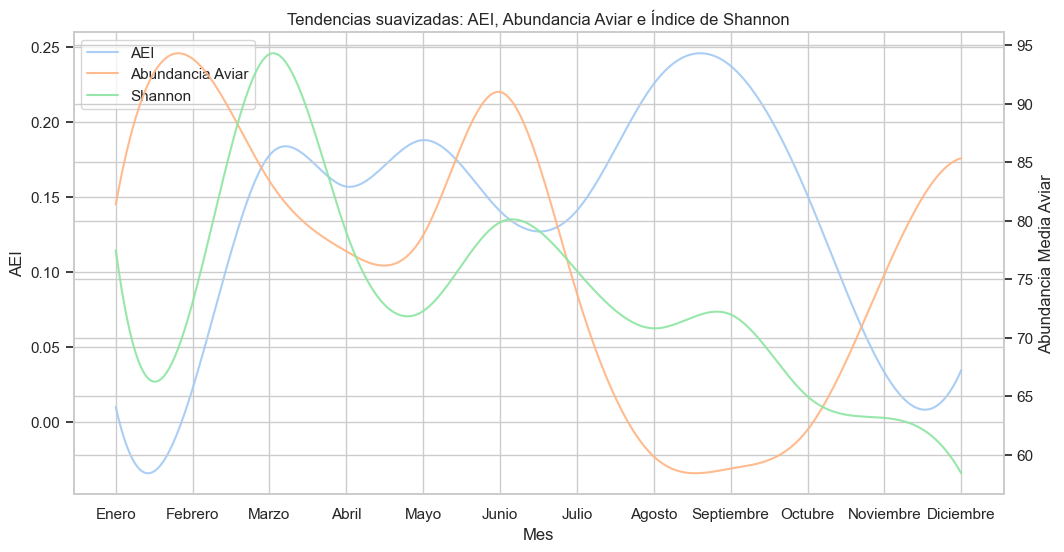

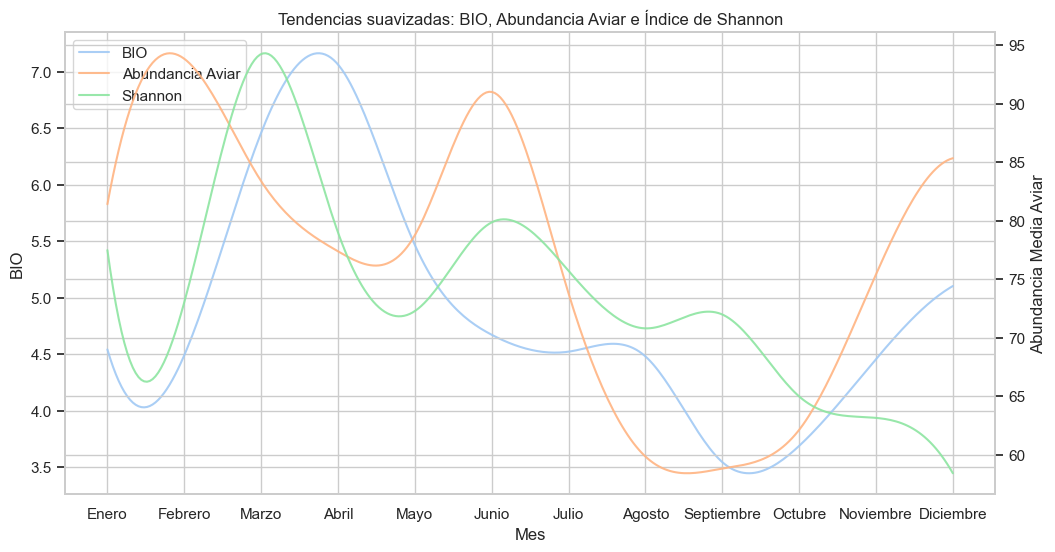

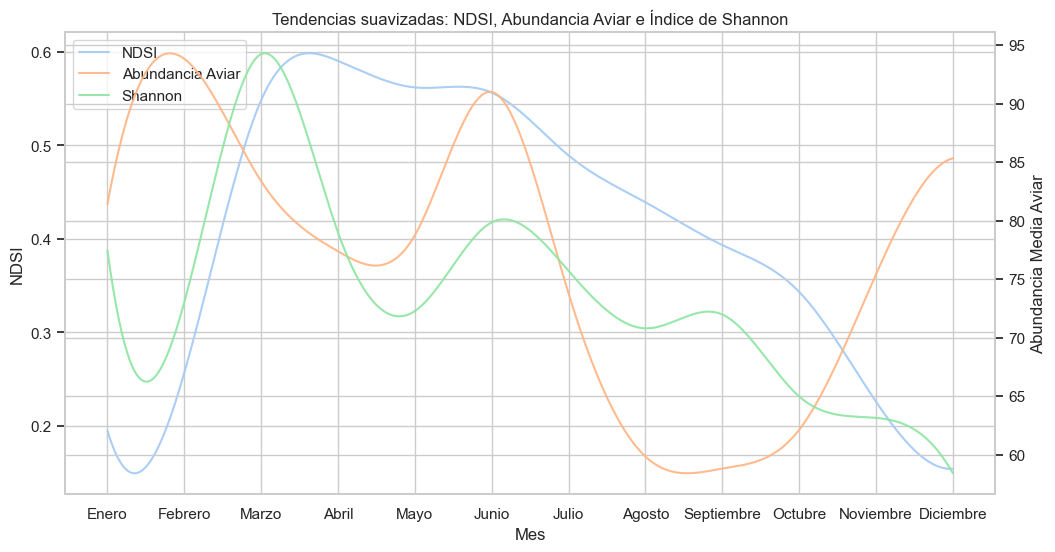

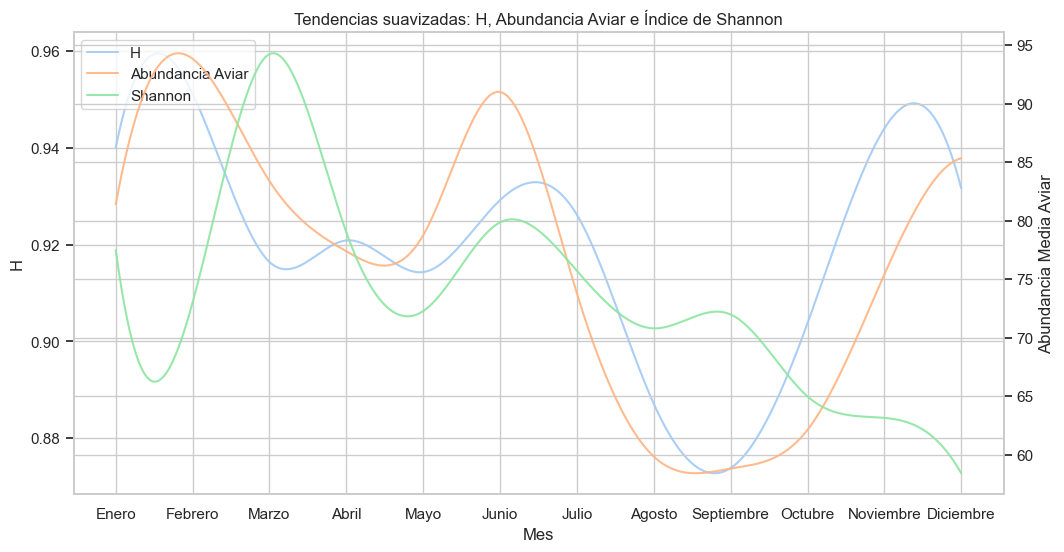

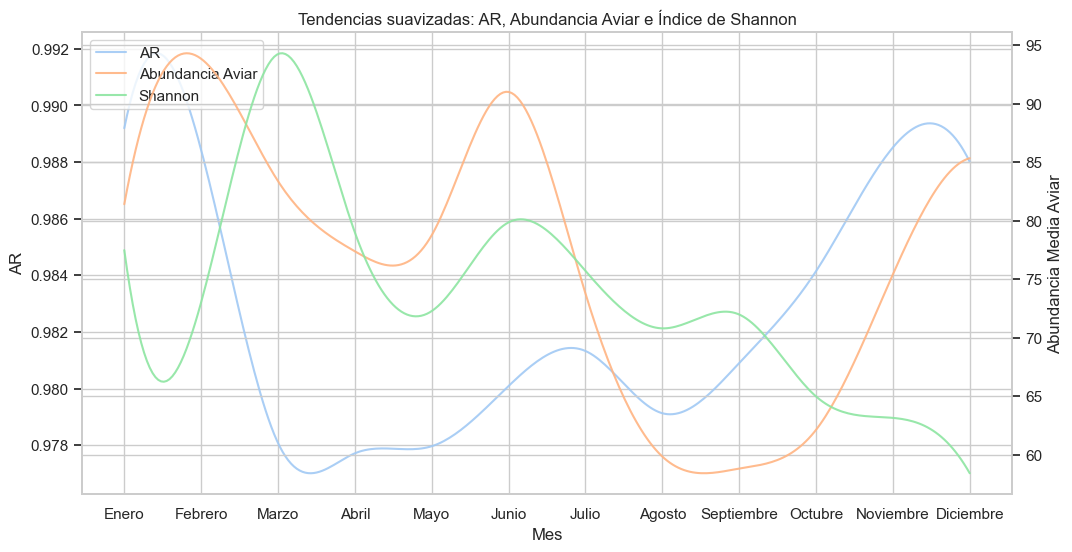

In [28]:
from scipy.interpolate import make_interp_spline

for idx in indices:
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Eje X: valores numéricos (meses) y nombres de los meses
    x = audio_monthly["month"]
    x_labels = audio_monthly["month_name"]
    x_smooth = np.linspace(x.min(), x.max(), 300)

    # --- Índice acústico suavizado ---
    y_idx = audio_monthly[idx]
    spline_idx = make_interp_spline(x, y_idx, k=3)
    y_smooth_idx = spline_idx(x_smooth)
    ax1.plot(x_smooth, y_smooth_idx, color=index_color, alpha=0.9, label=f"{idx}")

    # --- Abundancia aviar suavizada ---
    y_bird = obs_monthly["avg_bird_count"]
    ax2 = ax1.twinx()
    spline_bird = make_interp_spline(x, y_bird, k=3)
    y_smooth_bird = spline_bird(x_smooth)
    ax2.plot(x_smooth, y_smooth_bird, color=bird_color, alpha=0.9, label="Abundancia Aviar")

    # --- Índice de Shannon suavizado ---
    y_shannon = shannon_index_monthly["shannon_index"]
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    spline_shannon = make_interp_spline(x, y_shannon, k=3)
    y_smooth_shannon = spline_shannon(x_smooth)
    ax3.plot(x_smooth, y_smooth_shannon, color=shannon_color, alpha=0.9, label="Shannon")

    # Configurar ejes
    ax1.set_xlabel("Mes")
    ax1.set_xticks(x)
    ax1.set_xticklabels(x_labels)
    ax1.set_ylabel(f"{idx}")
    ax2.set_ylabel("Abundancia Media Aviar")
    ax3.set_ylabel("Índice de Shannon")
    ax1.tick_params(axis='y')
    ax2.tick_params(axis='y')
    ax3.tick_params(axis='y')
    ax3.yaxis.set_visible(False)

    # Título
    plt.title(f"Tendencias suavizadas: {idx}, Abundancia Aviar e Índice de Shannon")

    # Leyenda interna en esquina superior izquierda del eje principal
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines1 + lines2 + lines3,
               labels1 + labels2 + labels3,
               loc='upper left', frameon=True)


In [6]:
# Unir el índice de Shannon con los índices acústicos por mes
merged_data = pd.merge(audio_monthly, shannon_index_monthly, on="month")

correlation_results = merged_data[["shannon_index"] + indices].corr()

correlation_results = correlation_results["shannon_index"].drop("shannon_index")
print("Correlación entre el índice de Shannon y los índices acústicos por mes:")
print(correlation_results)

Correlación entre el índice de Shannon y los índices acústicos por mes:
ACI     0.383360
ADI    -0.135297
AEI     0.312805
BIO     0.526198
NDSI    0.638321
H      -0.022511
AR     -0.543657
Name: shannon_index, dtype: float64


In [7]:
max_lag = 3  # máximo desfase a considerar
lags = range(-max_lag, max_lag + 1)

cross_corr_results = pd.DataFrame(index=lags, columns=indices)

for col in indices:
    for lag in lags:
        # Se desplaza la serie del índice acústico en función del desfase
        shifted_series = merged_data[col].shift(lag)
        # Se calcula la correlación entre el índice de Shannon y la serie desplazada
        cross_corr_results.loc[lag, col] = merged_data['shannon_index'].corr(shifted_series)

print("Cross-Correlation (correlación cruzada) mes a mes:")
print(cross_corr_results)


Cross-Correlation (correlación cruzada) mes a mes:
         ACI       ADI       AEI       BIO      NDSI         H        AR
-3  0.251498 -0.135009  0.210564 -0.071951  0.508853  0.029882 -0.357026
-2  0.450905 -0.412693  0.562876  0.147135  0.628216 -0.243615 -0.655302
-1  0.515216 -0.141869  0.330765    0.5555  0.678521 -0.041996 -0.589502
0    0.38336 -0.135297  0.312805  0.526198  0.638321 -0.022511 -0.543657
1   0.253133  0.299375 -0.180554  0.318408  0.153658   0.36433 -0.045407
2  -0.070858   0.79859 -0.734833  0.394542 -0.275533  0.724862  0.420025
3   0.085836  0.746583 -0.573751  0.672355 -0.014459  0.693825  0.190598


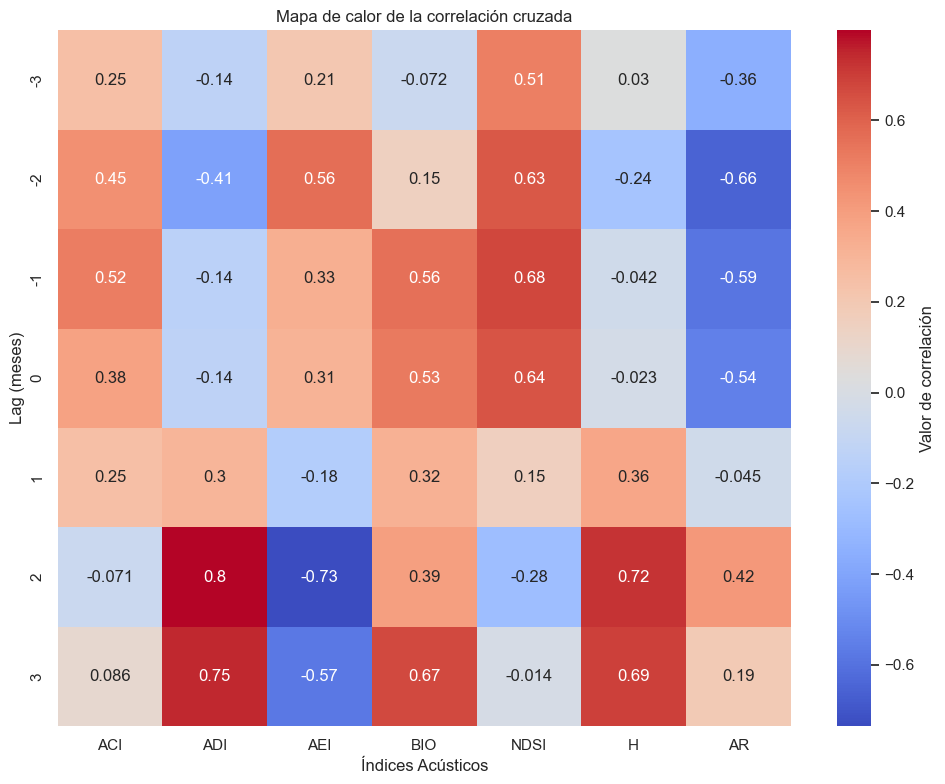

In [8]:
heatmap_data = cross_corr_results.astype(float)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Valor de correlación'})

plt.xlabel('Índices Acústicos')
plt.ylabel('Lag (meses)')
plt.title('Mapa de calor de la correlación cruzada')
plt.tight_layout()
plt.show()